# Sensitivity Analysis of Time Series Model Predictions

This project performs a sensitivity analysis on a time series forecasting model by evaluating how perturbations in external features affect predicted outcomes. The analysis involves the following steps:

1. **Model Fitting**: Train a SARIMAX model using historical data and exogenous features.
2. **Perturbation**: Adjust each exogenous feature by a specified factor (both positively and negatively).
3. **Forecasting**: Generate predictions based on the perturbed feature values.
4. **Visualization**: Plot the original predictions alongside the predictions from perturbed features to assess the impact of each feature.

## Tags
- `Time Series Analysis`
- `ARIMA`
- `SARIMAX`
- `Sensitivity Analysis`
- `Forecasting`
- `Python`

In [13]:
# Import necessary libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.stats.stattools import jarque_bera
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.stats.stattools import durbin_watson
import seaborn as sns

In [2]:
# Fetch historical stock data for AAPL
end = datetime.now()
data = yf.download('AAPL', start=end - timedelta(days=15*365), end=end, interval='1d', auto_adjust=True)

# Display first few rows of data
data.head()

# Display information about the dataset
data.info()

[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3772 entries, 2009-10-02 to 2024-09-27
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    3772 non-null   float64
 1   High    3772 non-null   float64
 2   Low     3772 non-null   float64
 3   Close   3772 non-null   float64
 4   Volume  3772 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 176.8 KB


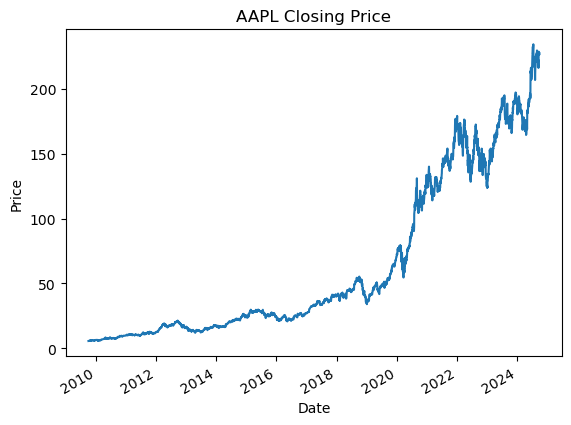

,count,mean,std,min,25%,50%,75%,max
Open,3772.0,6.369788e+01,6.226764e+01,5.471294e+00,1.699872e+01,3.295107e+01,1.211984e+02,2.362066e+02
High,3772.0,6.437524e+01,6.293949e+01,5.607917e+00,1.713521e+01,3.311751e+01,1.223606e+02,2.369557e+02
Low,3772.0,6.305338e+01,6.164436e+01,5.469484e+00,1.681705e+01,3.276367e+01,1.190972e+02,2.328205e+02
Close,3772.0,6.374263e+01,6.232253e+01,5.576551e+00,1.698178e+01,3.294991e+01,1.207253e+02,2.345485e+02
Volume,3772.0,2.378429e+08,2.210497e+08,2.404830e+07,8.766230e+07,1.461214e+08,3.263071e+08,1.880998e+09


In [3]:
# Plot the closing price of AAPL
data['Close'].plot(title='AAPL Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# Show statistical summary of the dataset
data.describe().T

In [4]:
# Feature engineering: Calculate relevant indicators
data['O-C'] = data['Open'] - data['Close']  # Open-Close
data['H-L'] = data['High'] - data['Low']    # High-Low
data['HC_'] = data['High'] / data['Low'] - 1 # High-Low ratio
data['Returns'] = data['Close'].pct_change()  # Daily returns

# Rolling statistics for standard deviation and upper bound
data['STD'] = data['Returns'].rolling(7).std()
data['UB'] = data['Close'].rolling(7).mean() + data['Close'].rolling(7).std()*2

# Drop missing values
data.dropna(inplace=True)

In [5]:
# Calculate Momentum, Moving Average, and Exponential Moving Average
data['Momentum'] = data['Close'] - data['Close'].shift(5)  # 5-day Momentum
data['MA'] = data['Close'].rolling(20).mean()              # 20-day Moving Average
data['EMA'] = data['Close'].ewm(span=20, adjust=False).mean()  # 20-day Exponential Moving Average

# Drop missing values again after creating new features
data.dropna(inplace=True)

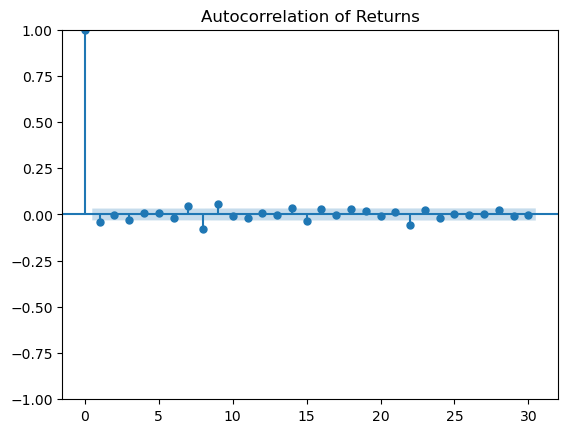

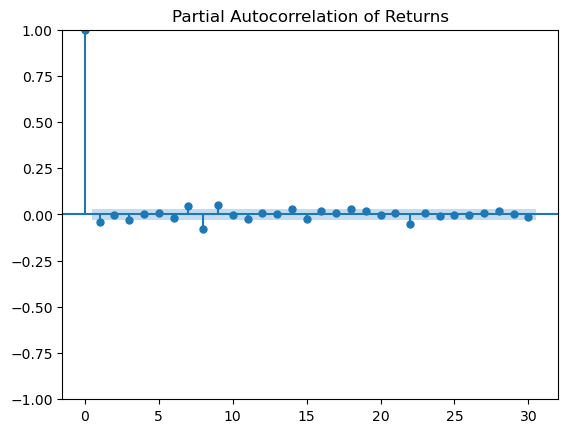

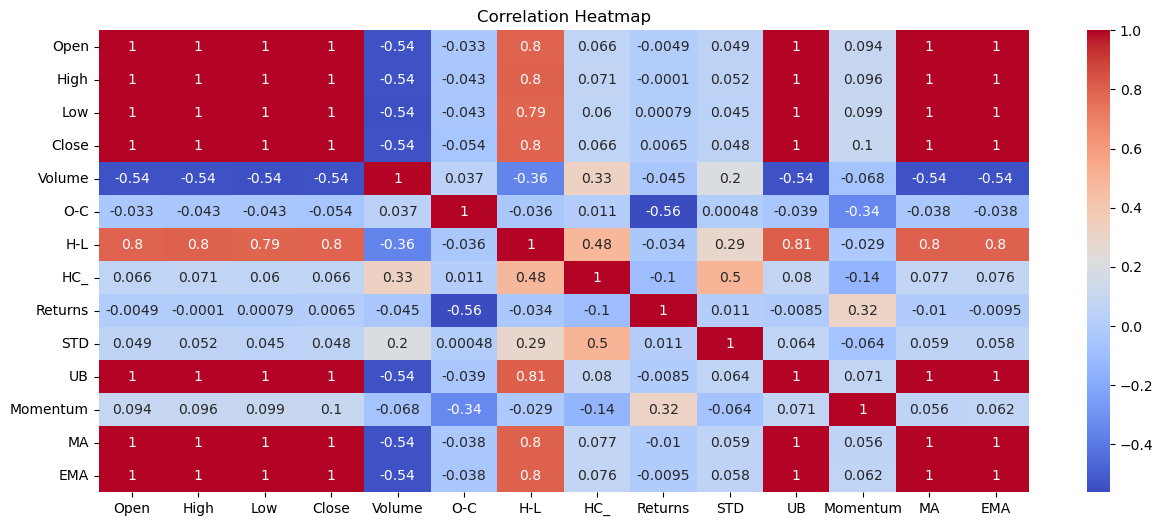

In [6]:
# Autocorrelation and Partial Autocorrelation Plots
plot_acf(data.Returns, lags=30, title='Autocorrelation of Returns')
plt.show()

plot_pacf(data.Returns, lags=30, title='Partial Autocorrelation of Returns')
plt.show()

# Correlation heatmap
corr = data.corr()
plt.figure(figsize=(15, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [15]:
# Stationarity Test: Augmented Dickey-Fuller Test
adf_stat, p_value, _, _, critical_values,_ = adfuller(data['Returns'].dropna())
print(f'ADF Statistic: {adf_stat}, p-value: {p_value}')
print(f'Critical Values: {critical_values}')

# Check stationarity based on p-value
if p_value < 0.05:
    print("The data is stationary.")
else:
    print("The data is non-stationary. Consider differencing or transformation.")

ADF Statistic: -20.37652323772259, p-value: 0.0
Critical Values: {'1%': -3.4321010830950787, '5%': -2.862313731833426, '10%': -2.5671818682559446}
The data is stationary.


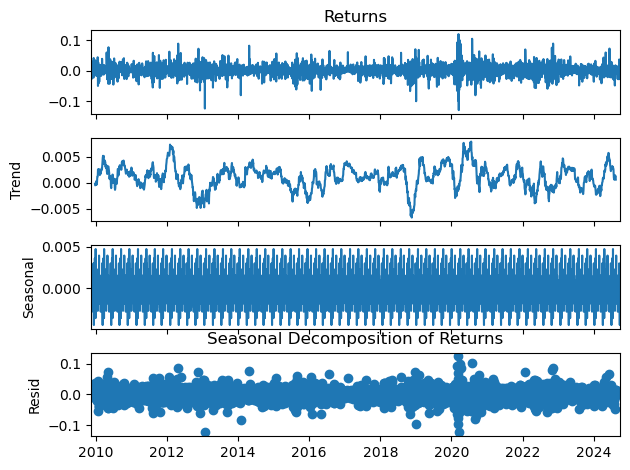

In [7]:
# Seasonal decomposition of the returns
seasonal_add = seasonal_decompose(data.Returns, model='additive', period=60)
seasonal_add.plot()
plt.title('Seasonal Decomposition of Returns')
plt.show()

In [8]:
# Prepare data for modeling
X = data.Returns
exog_features = ['O-C', 'Momentum', 'HC_', 'STD']
X_exog = data[exog_features]

# Split data into training and test sets (80/20)
split_point = int(len(data.Returns) * 0.8)
X_train = X[:split_point]
X_test = X[split_point:]
X_exog_train = X_exog[:split_point]
X_exog_test = X_exog[split_point:]

In [9]:
# Scale the exogenous features
scaler = StandardScaler()
X_exog_train_scaled = scaler.fit_transform(X_exog_train)
X_exog_test_scaled = scaler.transform(X_exog_test)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[60] intercept   : AIC=-15663.842, Time=41.22 sec
 ARIMA(0,0,0)(0,0,0)[60] intercept   : AIC=-15667.865, Time=0.18 sec
 ARIMA(1,0,0)(1,0,0)[60] intercept   : AIC=-15672.106, Time=41.31 sec
 ARIMA(0,0,1)(0,0,1)[60] intercept   : AIC=-15671.919, Time=32.10 sec
 ARIMA(0,0,0)(0,0,0)[60]             : AIC=-15655.916, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[60] intercept   : AIC=-15674.080, Time=0.14 sec
 ARIMA(1,0,0)(0,0,1)[60] intercept   : AIC=-15672.104, Time=64.74 sec
 ARIMA(1,0,0)(1,0,1)[60] intercept   : AIC=-15670.062, Time=21.27 sec
 ARIMA(2,0,0)(0,0,0)[60] intercept   : AIC=-15672.351, Time=0.51 sec
 ARIMA(1,0,1)(0,0,0)[60] intercept   : AIC=-15673.178, Time=0.36 sec
 ARIMA(0,0,1)(0,0,0)[60] intercept   : AIC=-15673.931, Time=0.51 sec
 ARIMA(2,0,1)(0,0,0)[60] intercept   : AIC=-15670.307, Time=1.31 sec
 ARIMA(1,0,0)(0,0,0)[60]             : AIC=-15660.670, Time=0.10 sec

Best model:  ARIMA(1,0,0)(0,0,0)[60] intercept
Total f

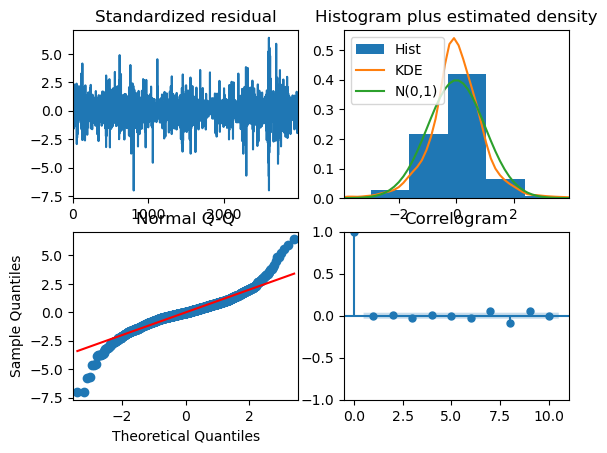

In [10]:
# Fit SARIMAX model with automatic order selection
model_auto = auto_arima(X_train, exogenous=X_exog_train_scaled,
                         start_p=0, max_p=3,
                         start_q=0, max_q=3,
                         seasonal=True, m=60,
                         trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)

# Print summary of the auto ARIMA model
print(model_auto.summary())
model_auto.plot_diagnostics()
plt.show()

c:\Users\gongo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\gongo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                Returns   No. Observations:                 2996
Model:               SARIMAX(1, 0, 0)   Log Likelihood                8496.101
Date:                Fri, 27 Sep 2024   AIC                         -16980.203
Time:                        20:41:15   BIC                         -16944.173
Sample:                             0   HQIC                        -16967.242
                               - 2996                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0092      0.000    -54.920      0.000      -0.010      -0.009
x2             0.0026      0.000     14.850      0.000       0.002       0.003
x3            -0.0017      0.000     -7.682      0.0

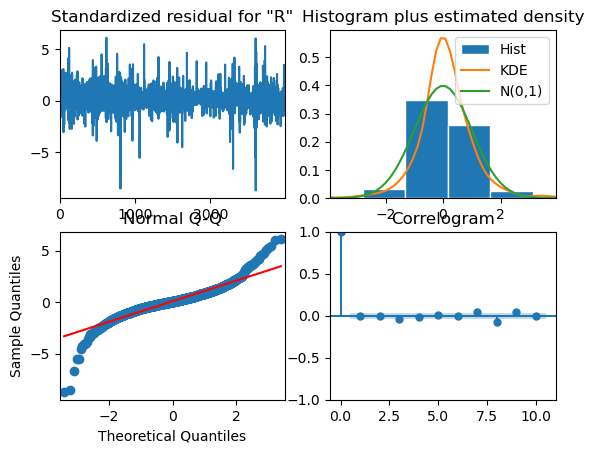

In [16]:
# Fit the final SARIMAX model using the selected orders
order = model_auto.order
season_order = model_auto.seasonal_order

model_exog = SARIMAX(X_train, exog=X_exog_train_scaled, order=order, seasonal_order=season_order)
model_exog_fit = model_exog.fit()

# Print the summary of the fitted model
print(model_exog_fit.summary())
model_exog_fit.plot_diagnostics()
plt.show()

c:\Users\gongo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\gongo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


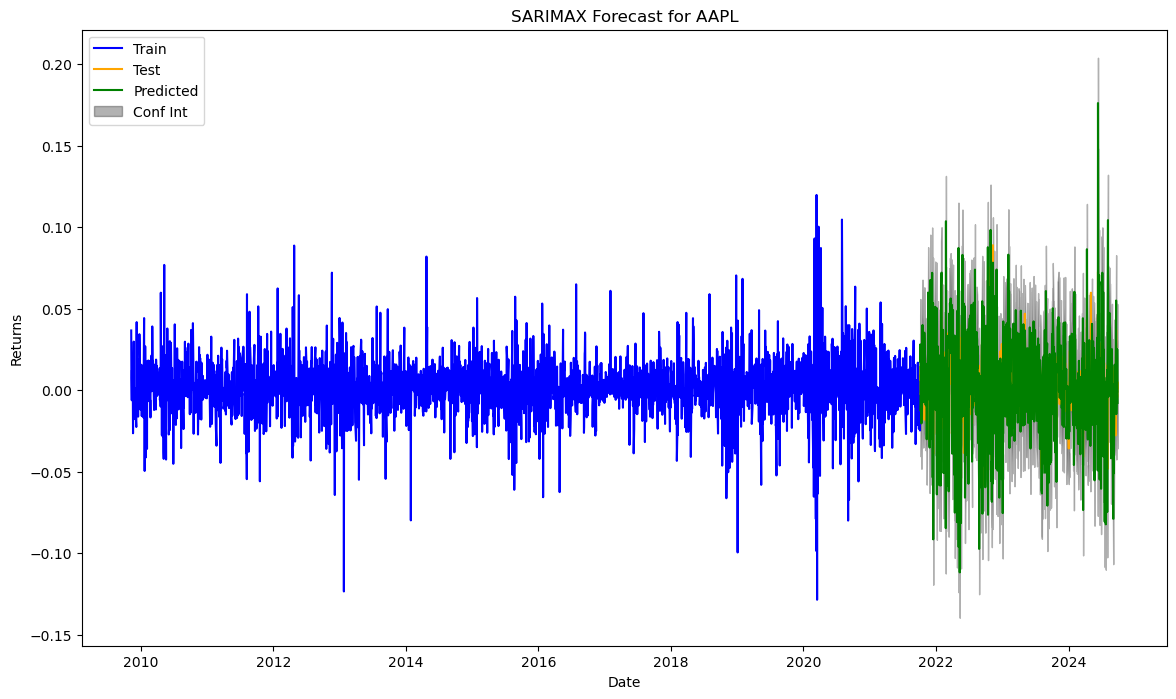

In [17]:
# Forecast using the fitted model
predictions = model_exog_fit.get_forecast(steps=len(X_test), exog=X_exog_test_scaled)
predicted_mean = predictions.predicted_mean

# Plot actual vs predicted values
plt.figure(figsize=(14, 8))
plt.plot(X_train, label='Train', color='blue')
plt.plot(X_test, label='Test', color='orange')
plt.plot(X_test.index, predicted_mean, label='Predicted', color='green')
conf_int = predictions.conf_int()
plt.fill_between(X_test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='black', alpha=0.3, label='Conf Int')
plt.title('SARIMAX Forecast for AAPL')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()

In [18]:
# Calculate model accuracy metrics
mae_sarimax = mean_absolute_error(X_test, predicted_mean)
mse_sarimax = mean_squared_error(X_test, predicted_mean)
rmse_sarimax = mean_squared_error(X_test, predicted_mean, squared=False)

print(f'MAE: {mae_sarimax}, MSE: {mse_sarimax}, RMSE: {rmse_sarimax}')

MAE: 0.016153225088994725, MSE: 0.0004748369284215951, RMSE: 0.02179075327797539


c:\Users\gongo\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [21]:
# Perform Durbin-Watson test for autocorrelation of residuals
dw_stat = durbin_watson(model_exog_fit.resid)
print(f'Durbin-Watson statistic: {dw_stat}')

# Jarque-Bera test for normality of residuals
jb_stat, jb_p_value,*_ = jarque_bera(model_exog_fit.resid)
print(f'Jarque-Bera Statistic: {jb_stat}, p-value: {jb_p_value}')

Durbin-Watson statistic: 1.9983167174855359
Jarque-Bera Statistic: 9108.296909710616, p-value: 0.0


In [24]:
# Define a function to perform sensitivity analysis
def sensitivity_analysis(model, exog_features, base_data, perturbation_factor=0.05):
    sensitivity_results = {}
    
    for feature in exog_features:
        original_values = base_data[feature].copy()
        
        # Perturb the feature values positively and negatively
        perturbed_values_positive = original_values * (1 + perturbation_factor)
        perturbed_values_negative = original_values * (1 - perturbation_factor)

        # Create a DataFrame to hold perturbed data
        perturbed_data = base_data.copy()
        
        # Evaluate forecast with perturbed positive values
        perturbed_data[feature] = perturbed_values_positive
        forecast_positive = model.get_forecast(steps=len(X_test), 
                                                exog=scaler.transform(perturbed_data[exog_features].iloc[-len(X_test):]))
        predicted_positive = forecast_positive.predicted_mean
        
        # Evaluate forecast with perturbed negative values
        perturbed_data[feature] = perturbed_values_negative
        forecast_negative = model.get_forecast(steps=len(X_test), 
                                                exog=scaler.transform(perturbed_data[exog_features].iloc[-len(X_test):]))
        predicted_negative = forecast_negative.predicted_mean
        
        # Store results with proper indexing
        sensitivity_results[feature] = {
            'original': predicted_mean,
            'positive_perturbation': predicted_positive,
            'negative_perturbation': predicted_negative
        }
        
        # Assign a proper index to the predictions
        predicted_index = pd.date_range(start=X_test.index[-1] + pd.Timedelta(days=1), 
                                         periods=len(predicted_positive), freq='B')
        sensitivity_results[feature]['original'].index = predicted_index
        sensitivity_results[feature]['positive_perturbation'].index = predicted_index
        sensitivity_results[feature]['negative_perturbation'].index = predicted_index
        
    return sensitivity_results


c:\Users\gongo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\gongo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\gongo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\gongo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_predicti

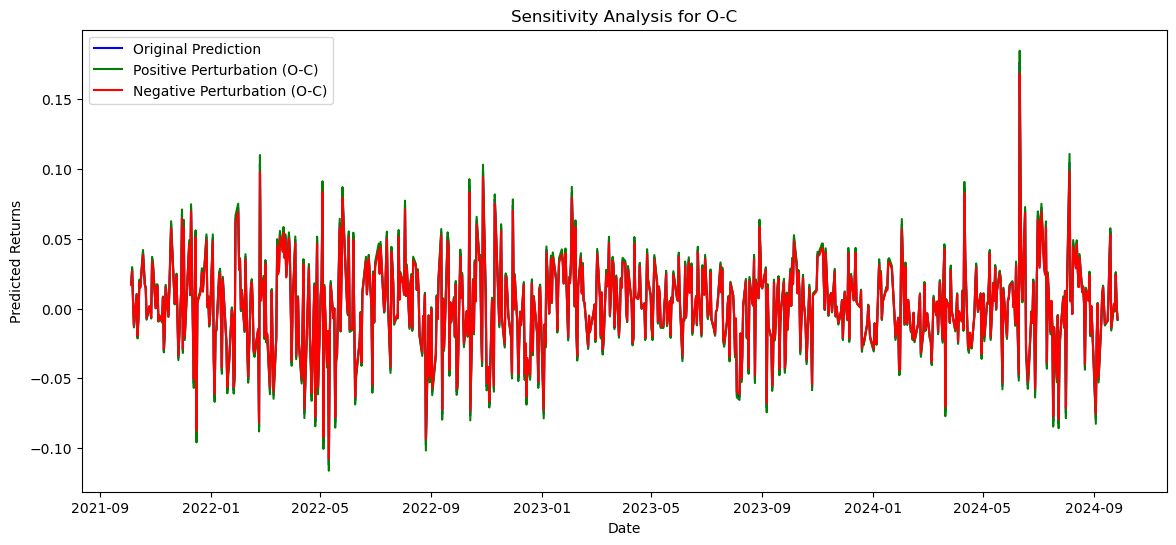

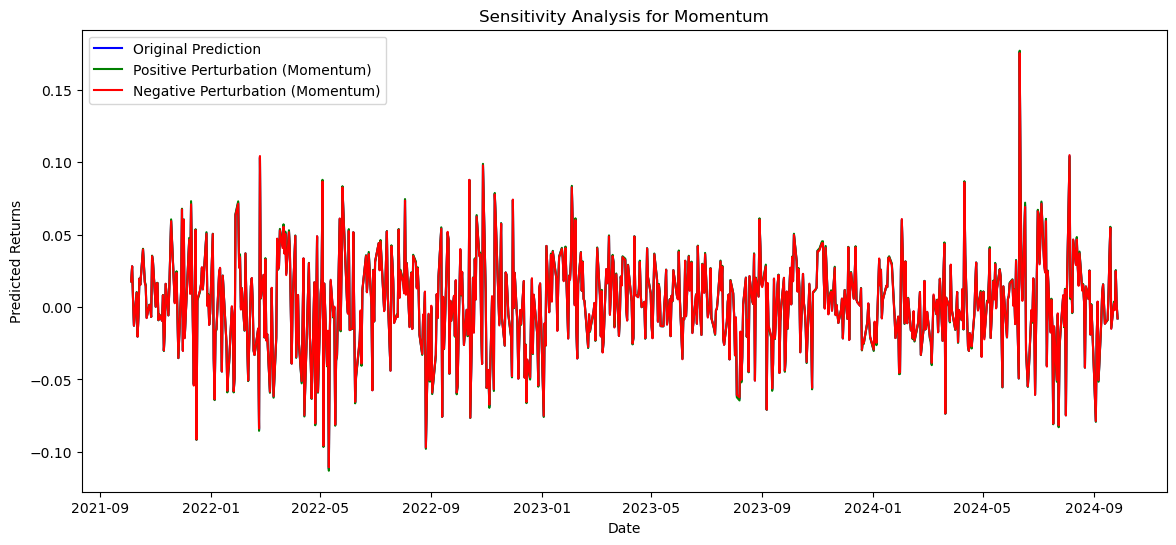

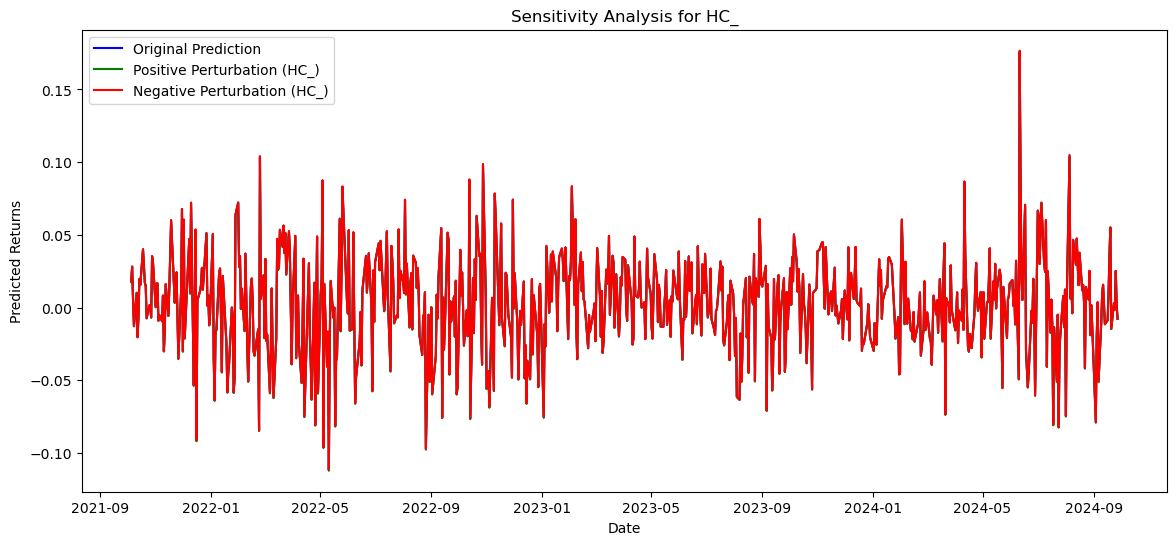

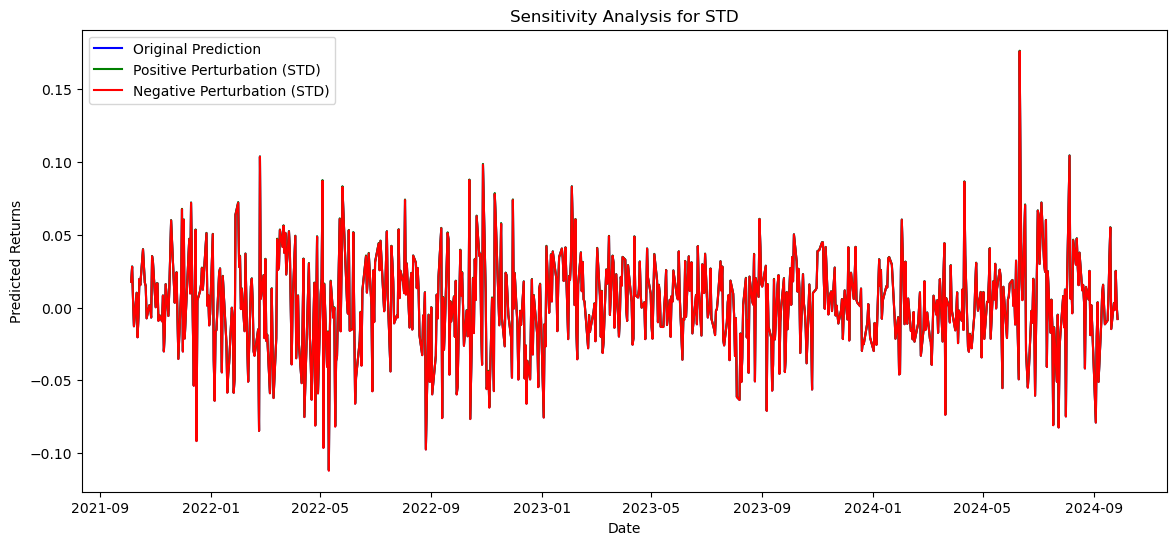

In [25]:
# Perform sensitivity analysis
sensitivity_results = sensitivity_analysis(model_exog_fit, exog_features, data)

# Display sensitivity analysis results
for feature, results in sensitivity_results.items():
    plt.figure(figsize=(14, 6))
    plt.plot(X_test.index, results['original'], label='Original Prediction', color='blue')
    plt.plot(X_test.index, results['positive_perturbation'], label=f'Positive Perturbation ({feature})', color='green')
    plt.plot(X_test.index, results['negative_perturbation'], label=f'Negative Perturbation ({feature})', color='red')
    plt.title(f'Sensitivity Analysis for {feature}')
    plt.xlabel('Date')
    plt.ylabel('Predicted Returns')
    plt.legend()
    plt.show()